In [1]:
import numpy as np
import torch
import pandas as pd
from IPython.display import Audio
import seaborn as sns
import tqdm
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
import utils
import models
import trainer

In [3]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
#     hop_length = 694*duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    trim_long_data=True

In [4]:
conf.columns, conf.column_encoder = utils.read_columns()

In [5]:
# all_x, all_y, _ = torch.load("./train_curated_preprocessed.tc")
all_x, all_y, _ = utils.read_dataset("./data/train_curated", conf, lambda s: s)

100%|██████████| 4970/4970 [02:48<00:00,  7.74it/s] 


In [6]:
np.random.seed(42)
train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size=0.1)

In [13]:
test_x = list(map(lambda s: utils.audio_to_melspectrogram(conf, s), test_x))

In [14]:

train_dataset = trainer.SoundAugDataset(train_x, train_y, lambda s: utils.audio_to_melspectrogram(conf, s), max_size=10000, max_n_mixed=3, seed=42)
test_dataset = trainer.SoundDataset(test_x, test_y)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)

In [16]:
device = torch.device("cuda")
# model = models.Net(128, all_x[0].shape[-1], 80)
model = models.LSTMModel(128, 80)
model = model.to(device)

In [17]:
tr = trainer.Trainer(model, torch.optim.Adam, device, {"path":"./experiments/lstm/"})

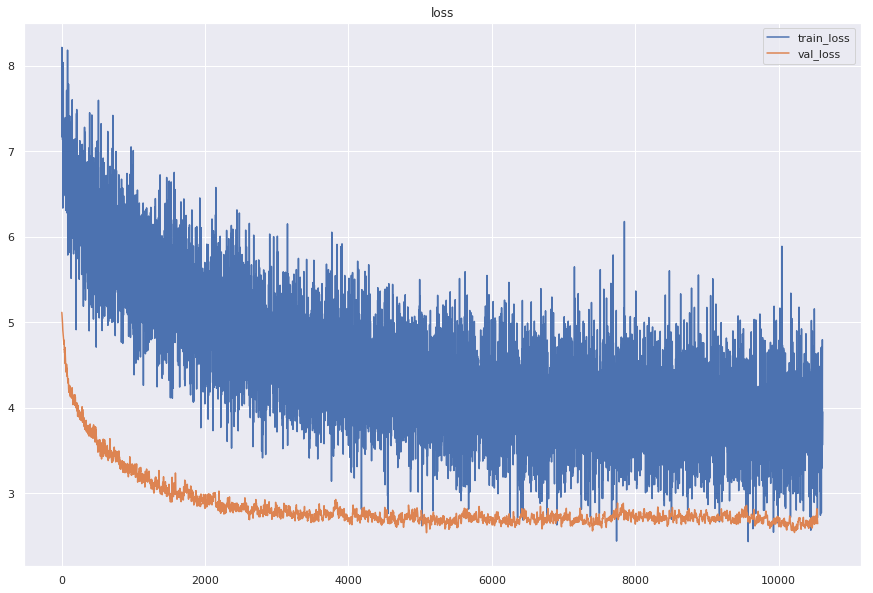

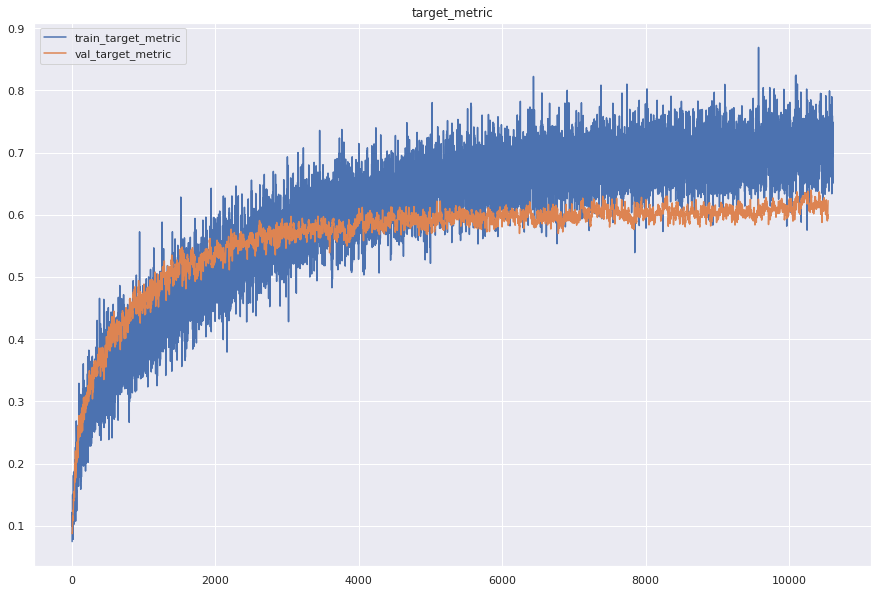

In [ ]:
tr.train(
    loaders={"train_loader":train_loader, "test_loader":test_loader},
    params={"epochs":50, "grad_clip_norm":10.0, "validate_every":25},
)

In [29]:
min(tr.val_metrics['loss']), tr.val_metrics['loss'][-100:]

(2.515965991336815,
 [2.6000403326521937,
  2.6165390235317543,
  2.6231772630987034,
  2.625501258512378,
  2.6316094844633904,
  2.629202800977158,
  2.629731332272351,
  2.6256866176843165,
  2.618589685236664,
  2.6192938535506096,
  2.619191050289622,
  2.6184756031458525,
  2.6298990124907773,
  2.6367825008254178,
  2.650117035123184,
  2.657341710038828,
  2.6625534682206706,
  2.666835801222435,
  2.6662740923269412,
  2.661195180785488,
  2.645447321820787,
  2.6350051776264274,
  2.6246188684728304,
  2.6172167986211643,
  2.615222284251775,
  2.6162851590745646,
  2.612633398600987,
  2.60430559258106,
  2.5925659130756524,
  2.591705340494812,
  2.591411797333531,
  2.585438759034308,
  2.576651027744685,
  2.5704389266085097,
  2.5768905520679004,
  2.5897875753206985,
  2.593716008802295,
  2.590086196749743,
  2.5992150450616296,
  2.6056898978634377,
  2.610789240965661,
  2.614738436531973,
  2.6265683562702815,
  2.6341773537802746,
  2.6363391876220703,
  2.63430404

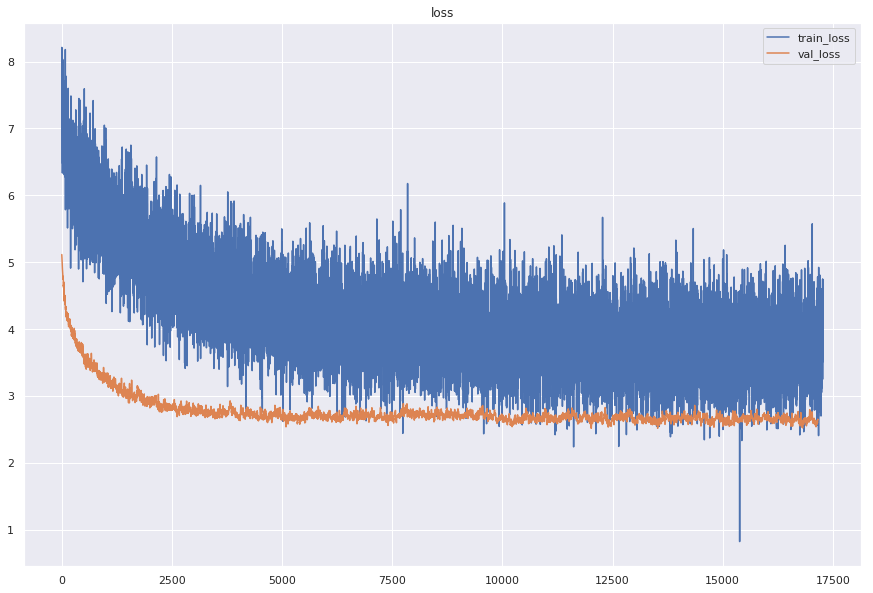

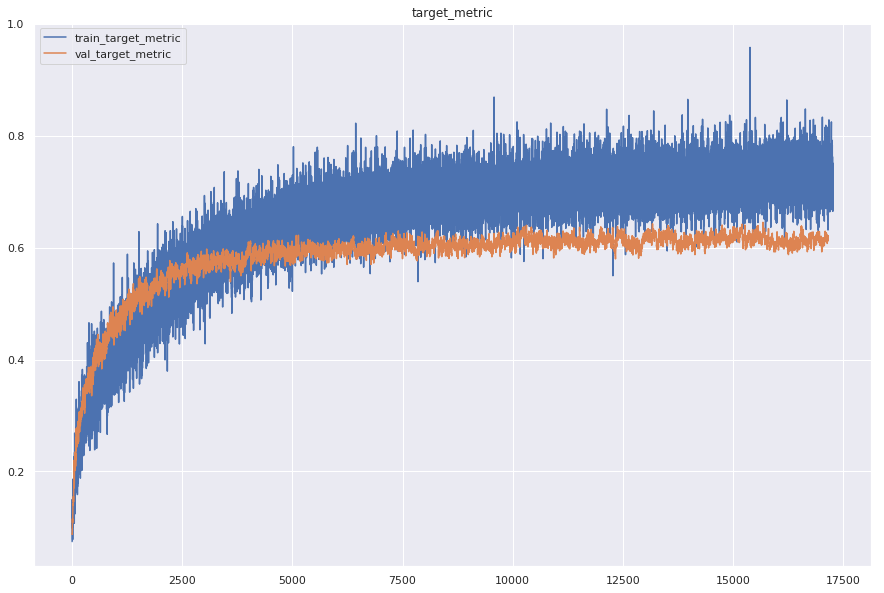

In [26]:
tr.plot(tr.train_metrics, tr.val_metrics)